In [22]:
import os
import csv
import re
import matplotlib.pyplot as plt
import numpy as np

from pybeerxml.parser import Parser

In [120]:
# Create a yeast name-to-id system
yeast_name_to_id = {}
brand_to_ids = {}
id_to_yeast_names = {}
with open("./data/_db/yeasts.csv", "r", encoding="utf-8") as f:
    csv_reader = csv.reader(f, delimiter=";")
    for i,row in enumerate(csv_reader):
        if i == 0: continue
        names = []
        yeast_name = row[0].lower()
        yeast_name_to_id[yeast_name] = i
        names.append(yeast_name)
        
        for alt_name in row[1].split(",") + row[2].split(","):
            if len(alt_name) > 0:
                alt_name = alt_name.lower()
                yeast_name_to_id[alt_name] = i
                names.append(alt_name)
                
        for product_id in row[7].split(",") + row[8].split(","):
            if len(product_id) > 0:
                product_id = product_id.lower()
                yeast_name_to_id[product_id] = i
                names.append(product_id)
        assert len(names) > 0
        id_to_yeast_names[i] = names
        
        for brand in row[5].split(",") + row[6].split(","):
            if len(brand) > 0:
                if brand not in brand_to_ids:
                    brand_to_ids[brand] = []
                brand_to_ids[brand].append(i)
       

In [121]:
yeast_name_to_id['munton']

708

In [126]:
ogs = []
fgs = []
yeasts = set()
malts = set()

parser = Parser()
dir_count = 0

def clean_replace(s, target):
    return s.replace(target, '').replace("  ", " ").strip()

for dirpath, dirnames, files in os.walk('./data/_matched'):
    if dir_count < 20: 
        dir_count += 1
        continue
    dir_count += 1
    
    for file_name in files:
        file_path = str(os.path.join(dirpath, file_name))
        try:
            recipes = parser.parse(file_path)
        except:
            print("Erroneous file found, removing: " + file_path)
            os.remove(file_path)
        recipe = recipes[0]
        ogs.append(recipe.og)
        fgs.append(recipe.fg)
        
        for y in recipe.yeasts:
            
            if not isinstance(y.name, str):
                # Try turning the name into a code (likely a wyeast strain)...
                yeast_name = str(int(y.name))
            else:
                yeast_name = y.name.lower()
                # Some basic clean-up to start...
                yeast_name = yeast_name.replace("kรถlsch","kolsch").replace("kรถlsh","kolsch").replace("kölsh","kolsch")
                yeast_name = yeast_name.replace("monastery","monastary").replace("monestary","monastary")
                yeast_name = yeast_name.replace("california v ale", "california ale v")
                if "conan" in yeast_name: yeast_name = "vermont ale"
                elif "super high gravity" in yeast_name or "wlp 099" in yeast_name: yeast_name = "super high gravity ale"
                elif "chico" in yeast_name: yeast_name = "chico ale"
                else:
                    pass
                
                
            if yeast_name not in yeast_name_to_id:
                # First attempt: Try to find a yeast code to match
                s = re.search(r"(wlp|us\-|([kwst]|oyl)\-|[mg]|\d+/)\s?(\d+(/\d+)?)", yeast_name, flags=re.IGNORECASE)
                if s != None and len(s.group()) > 0:
                    # We have a potential yeast product id...
                    product_id = s.group()
                    if product_id not in yeast_name_to_id:
                        print(f"Product id {product_id} not found for {yeast_name}, file: {file_path}")
                    continue
                
                # Try removing the word "yeast" (and watch out for any double spaces that may ensue)
                if clean_replace(yeast_name, "yeast") in yeast_name_to_id:
                    continue
                # Try replacing "yeast" with "ale" or "lager"
                if yeast_name.replace("yeast", "ale") in yeast_name_to_id or yeast_name.replace("yeast", "lager") in yeast_name_to_id:
                    continue
                # Try adding "ale" or "blend" or "lager" to the end
                if yeast_name+" ale" in yeast_name_to_id or yeast_name+" lager" in yeast_name_to_id or yeast_name+" blend" in yeast_name_to_id:
                    continue
                
                # Check for a wyeast code (4 digit code)
                s = re.search(r"(\d{4})(\D+|$)", yeast_name, flags=re.IGNORECASE)
                if s != None and len(s.group(1)) > 0:
                    product_id = s.group(1)
                    if product_id not in yeast_name_to_id:
                        print(f"Product id {product_id} not found for {yeast_name}")
                    else:
                        continue
                
                # Try to match the brand name first and then try to figure out
                # which yeast we're dealing with within that brand 
                for brand_name, ids in brand_to_ids.items():
                    s = re.search(brand_name, yeast_name, flags=re.IGNORECASE)
                    if s != None and len(s.group()) > 0:
                        # Find the best possible match
                        best_match_count = 0
                        best_match_id = -1
                        for id in ids:
                            count = 0
                            potential_yeast_names = id_to_yeast_names[id]
                            for name in potential_yeast_names:
                                s = re.search(name, yeast_name, flags=re.IGNORECASE)
                                if s != None: count += 1
                            if count > best_match_count:
                                best_match_count = count
                                best_match_id = id
                        if best_match_id == -1:
                            # Just choose the first id...
                            assert len(ids) > 0
                            best_match_id = ids[0]
                            yeast_name = id_to_yeast_names[best_match_id][0]
                        else:
                            pass
                            #print(f"Found a brand-based match for '{yeast_name}', with brand '{brand_name}', and names: {id_to_yeast_names[best_match_id]}")
                            
                        break
                            
                
                # Last attempt - try to match any of the ids directly with the yeast name string
                found = False
                best_len = 0
                best_name = ""
                for dict_name in yeast_name_to_id:
                    name_opts = f"({dict_name}|{clean_replace(dict_name, 'ale')}|{clean_replace(dict_name,'lager')})"
                    s = re.search(name_opts, yeast_name)
                    if s != None and len(s.group()) > 0:
                        group_len = len(s.group())
                        if best_len < group_len:
                            best_len = group_len
                            best_name = dict_name
                            
                if best_len == 0:
                    if yeast_name == '- -' or yeast_name == 'default - - -' or '?' in yeast_name:
                        print(f"Deleting file with empty/unknown (e.g., '- -') yeast: {file_path}")
                        os.remove(file_path)
                    else:
                        print(f"No matches for '{yeast_name}', file: {file_path}")
                else:
                    pass
                    #print(f"Matched '{yeast_name}' with '{best_name}', file: {file_path}")
        
        #for m in recipe.fermentables:
        #    if m.type == None:
        #        print(f"Malt type none found in file {file_path}")
        #malts.update([m.name for m in recipe.fermentables])

Product id wlp0833 not found for white labs hells bock yeast wlp0833, file: ./data/_matched/102/bt_224430.xml
Product id 090/862 not found for blend 090/862, file: ./data/_matched/102/bt_163739.xml
No matches for 'default - - -', file: ./data/_matched/102/550304.xml
No matches for 'default - - -', file: ./data/_matched/102/618411.xml
No matches for 'brewferm lager', file: ./data/_matched/102/435648.xml
No matches for 'voss', file: ./data/_matched/102/bt_245003.xml
No matches for 'stranda', file: ./data/_matched/102/bt_245003.xml
Product id s-006 not found for eccentric ale yeast inis-006, file: ./data/_matched/56/409802.xml
No matches for 'default - - -', file: ./data/_matched/56/339545.xml
Product id m66 not found for hophead m66, file: ./data/_matched/56/537347.xml
Product id s-05 not found for s-05, file: ./data/_matched/56/499489.xml
Product id s-006 not found for eccentric ale yeast inis-006, file: ./data/_matched/56/480222.xml
Product id 9097 not found for wyeast #9097 old ale bl

FileNotFoundError: [Errno 2] No such file or directory: './data/_matched/111/191676.xml'

In [8]:
yeasts

{'Nottingham Ale Yeast',
 1.0,
 'American Ale Yeast INIS-007',
 'Nottingham Lallemand',
 'ECY12 Old Newark Beer',
 'us 05',
 'Burton Ale Yeast',
 'Safeale - American Ale Yeast US-05',
 'CL010 Moravian Vale',
 'Belgian Strong Ale',
 'Brewferm Top',
 'Vermont Ale (Yeast Bay)',
 'Brett D ',
 'Mud King',
 'London ESB Ale (WY1968)',
 'Munton',
 'London fog',
 'The Magi',
 'Sacc Trois',
 'Lallemand BRY-97',
 'house',
 'Fermentis WB-06 Dry Wheat Beer Yeast',
 'Fermentis SafAle S-05',
 'no yeast',
 'Nottingham ale',
 'Kรถlsh Bier',
 'Safale US-05, gÄ™stwa po rye ipa',
 'Weihenstephan Weizen',
 'Brettanomyces brux trois',
 'ECY 30 brett Naaredenensis',
 'Belgian Ardennes 3522',
 'Juice',
 'Mangrove Jack - Workhorse Yeast M10',
 'WLP066 London Fog',
 'LALBREW® BRY-97 WEST COAST ALE YEAST',
 'European Ale Yeast WLP011',
 'Mangrove Jacks - M36 Liberty Bell',
 'Safbrew - Abbaye Yeast',
 'U.S. West Coast (1 pack)',
 'Wyeast - American Ale',
 'American Ale - Escarpment Labs',
 'California Ale V Yeast

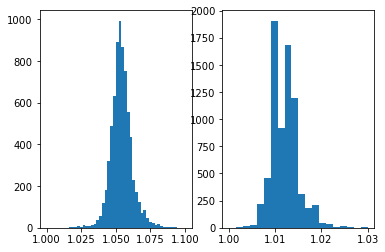

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(ogs, bins=50, range=(1.0, 1.1));
ax2.hist(fgs, bins=20, range=(1.0, 1.03));

In [86]:
ogs = np.array(ogs)
fgs = np.array(fgs)
print(ogs.mean(), ogs.std())
print(fgs.mean(), fgs.std())

1.053665150888797 0.009690755932266558
1.0119204905608377 0.0032176378292414834


In [88]:
n_ogs = (ogs - ogs.mean()) / ogs.std()
n_fgs = (fgs - fgs.mean()) / fgs.std()
print(n_ogs.mean(), n_ogs.std())
print(n_fgs.mean(), n_fgs.std())

-7.0745852793642054e-15 1.0
3.3299653359791936e-14 1.0
